# ZTF alerts triggered in TESS Northern Fields

[![Open In Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dmitryduev/kowalski/blob/master/nb/tess.ipynb)

The [Zwicky Transient Facility (ZTF)](https://ztf.caltech.edu) will conduct a public survey of all 13 TESS northern sectors in 2019-2020. The sectors (as much as is visible from the Palomar Observatory on a particular night) will be mapped every night in the $g$ and $r$ filters concurrently with the TESS observations. 

The observations of the first TESS Northern sector (sector 14) have begun on July 18, 2019. 

The ZTF alerts for the transient events discovered in the TESS fields will have the [alert packet](https://zwickytransientfacility.github.io/ztf-avro-alert/) field `programpi` in the `candidate` block set to `TESS`. Note that events may be triggered from transient, reoccurring variable, or moving objects.

A compressed nightly tar-ball with the alert packets converted into the `JSON` format will be immediately made available to the public via ZTF's bucket on `Google Cloud`. The alerts in the TESS fields will be additionally cross-matched against a number of external catalogs. Furthermore, we anticipate executing multiple machine learning (ML) classifiers on the alerts. Initially, the catalogs will include `2MASS_PSC`, `AllWISE`, `IPHAS_DR2`, and `Gaia_DR2` and the ML classifiers will include `braai`, a deep-learning-based real-bogus classifier.

## Accessing the alerts

### Downloading the data

If you have a `Google` account (any), you can access the nightly tar-balls at [https://console.cloud.google.com/storage/browser/ztf-tess](https://console.cloud.google.com/storage/browser/ztf-tess)

Alternatively, individual tar-balls may be downloaded at https://storage.googleapis.com/ztf-tess/YYYYMMDD.tar.gz

You can also list and download the data programmatically.

In [1]:
from IPython.core.display import display, HTML, JSON
!pip install requests
import requests

In [2]:
# a library to print large numbers in human-readable format
!pip install humanize
import humanize

Get a list of individual tar-ball meta-data:

In [3]:
r = requests.get('https://www.googleapis.com/storage/v1/b/ztf-tess/o')
tbs = r.json()['items']

In [4]:
for tb in tbs:
    display(HTML(f"""<a href="{tb['mediaLink']}">{tb['name']}</a> (size: {humanize.naturalsize(tb['size'])})"""))

Let's download and unpack the data for July 14, 2019.

In [5]:
!wget https://storage.googleapis.com/ztf-tess/20190714.tar.gz
#!tar -xf 20190714.tar.gz

In [6]:
import tarfile
from tqdm import tqdm

path = '20190714.tar.gz'

# open your tar.gz file
with tarfile.open(name=path) as tar:
    # Go over each member
    for member in tqdm(iterable=tar.getmembers(), total=len(tar.getmembers())):
        # Extract member
        tar.extract(member=member)

### Displaying the data

Let us load, parse, and display a few alerts.

In [7]:
import pandas as pd
import json
from bson.json_util import loads, dumps
import gzip
import io
import numpy as np
from astropy.io import fits
from astropy.time import Time
import datetime
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

Define a number of helper functions.

Make a `pandas` `DataFrame` out of an alert:

In [8]:
def make_dataframe(packet):
    df = pd.DataFrame(packet['candidate'], index=[0])
    df_prv = pd.DataFrame(packet['prv_candidates'])
    return pd.concat([df, df_prv], ignore_index=True, sort=False)

Convert the compressed `FITS` cutout images into a numpy array:

In [9]:
def make_triplet(alert, normalize: bool = False):
    """
        Feed in alert packet
    """
    cutout_dict = dict()

    for cutout in ('science', 'template', 'difference'):
        cutout_data = loads(dumps([alert[f'cutout{cutout.capitalize()}']['stampData']]))[0]

        # unzip
        with gzip.open(io.BytesIO(cutout_data), 'rb') as f:
            with fits.open(io.BytesIO(f.read())) as hdu:
                data = hdu[0].data
                # replace nans with zeros
                cutout_dict[cutout] = np.nan_to_num(data)
                # normalize
                if normalize:
                    cutout_dict[cutout] /= np.linalg.norm(cutout_dict[cutout])

        # pad to 63x63 if smaller
        shape = cutout_dict[cutout].shape
        if shape != (63, 63):
            cutout_dict[cutout] = np.pad(cutout_dict[cutout], [(0, 63 - shape[0]), (0, 63 - shape[1])],
                                         mode='constant', constant_values=1e-9)

    triplet = np.zeros((63, 63, 3))
    triplet[:, :, 0] = cutout_dict['science']
    triplet[:, :, 1] = cutout_dict['template']
    triplet[:, :, 2] = cutout_dict['difference']

    return triplet

Plot a cutout image triplet [science, reference, difference]:

In [10]:
def plot_triplet(tr):
    fig = plt.figure(figsize=(8, 2), dpi=120)
    ax1 = fig.add_subplot(131)
    ax1.axis('off')
    ax1.imshow(tr[:, :, 0], origin='upper', cmap=plt.cm.bone, norm=LogNorm())
    ax1.title.set_text('Science')
    ax2 = fig.add_subplot(132)
    ax2.axis('off')
    ax2.imshow(tr[:, :, 1], origin='upper', cmap=plt.cm.bone, norm=LogNorm())
    ax2.title.set_text('Reference')
    ax3 = fig.add_subplot(133)
    ax3.axis('off')
    ax3.imshow(tr[:, :, 2], origin='upper', cmap=plt.cm.bone)
    ax3.title.set_text('Difference')
    plt.show()

Simple check if an object has a stellar-like counterpart in the reference image:

In [11]:
def is_star(dflc, match_radius_arcsec=1.5, star_galaxy_threshold=0.4):
    try:
        return (dflc.iloc[-1].distpsnr1 < match_radius_arcsec) & (dflc.iloc[-1].sgscore1 > star_galaxy_threshold)
    except Exception as _e:
        print(_e)
        return False

Assemble objects light curve. The `candidate.magpsf` field present in the alert packets reports the flux in the difference image, and is positive by construction. Alerts however may be from positive or negative subtractions (as identified by the `candidate.isdiffpos` field), and for variable objects the flux in the reference image needs to be included.

In [12]:
def assemble_lc(dflc, objectId, composite=False, match_radius_arcsec=1.5, star_galaxy_threshold=0.4):
    # mjds:
    dflc['mjd'] = dflc.jd - 2400000.5

    dflc['datetime'] = dflc['mjd'].apply(lambda x: Time(x, format='mjd').datetime)
    
    # strings:
    dflc['dt'] = dflc['datetime'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))

    dflc.sort_values(by=['mjd'], inplace=True)

    # fractional days ago
    dflc['days_ago'] = dflc['datetime'].apply(lambda x:
                                              (datetime.datetime.utcnow() - x).total_seconds() / 86400.)

    if is_star(dflc, match_radius_arcsec=match_radius_arcsec, star_galaxy_threshold=star_galaxy_threshold):
        # print('It is a star!')
        # variable object/star? take into account flux in ref images:
        lc = []

        # fix old alerts:
        dflc.replace('None', np.nan, inplace=True)

        # prior to 2018-11-12, non-detections don't have field and rcid in the alert packet,
        # which makes inferring upper limits more difficult
        # fix using pdiffimfilename:
        w = dflc.rcid.isnull()
        if np.sum(w):
            dflc.loc[w, 'rcid'] = dflc.loc[w, 'pdiffimfilename'].apply(lambda x:
                                                      ccd_quad_2_rc(ccd=int(os.path.basename(x).split('_')[4][1:]),
                                                                    quad=int(os.path.basename(x).split('_')[6][1:])))
            dflc.loc[w, 'field'] = dflc.loc[w, 'pdiffimfilename'].apply(lambda x:
                                                                        int(os.path.basename(x).split('_')[2][1:]))

        grp = dflc.groupby(['fid', 'field', 'rcid'])
        impute_magnr = grp['magnr'].agg(lambda x: np.median(x[np.isfinite(x)]))
        impute_sigmagnr = grp['sigmagnr'].agg(lambda x: np.median(x[np.isfinite(x)]))

        for idx, grpi in grp:
            w = np.isnan(grpi['magnr'])
            w2 = grpi[w].index
            dflc.loc[w2, 'magnr'] = impute_magnr[idx]
            dflc.loc[w2, 'sigmagnr'] = impute_sigmagnr[idx]

        # fix weird isdiffpos'es:
        w_1 = dflc['isdiffpos'] == '1'
        dflc.loc[w_1, 'isdiffpos'] = 't'

        dflc['sign'] = 2 * (dflc['isdiffpos'] == 't') - 1

        # from ztf_pipelines_deliverables, reference image zps are fixed

        ref_zps = {1: 26.325, 2: 26.275, 3: 25.660}

        dflc['magzpref'] = dflc['fid'].apply(lambda x: ref_zps[x])

        # 'magzpsci' was not there in older alerts
        if 'magzpsci' in dflc.columns:
            w = dflc.magzpsci.isnull()
            dflc.loc[w, 'magzpsci'] = dflc.loc[w, 'magzpref']
        else:
            dflc['magzpsci'] = dflc['magzpref']

        dflc['ref_flux'] = 10 ** (0.4 * (dflc['magzpsci'] - dflc['magnr']))
        # dflc['ref_flux'] = 10 ** (0.4 * (dflc['magzpref'] - dflc['magnr']))

        dflc['ref_sigflux'] = dflc['sigmagnr'] / 1.0857 * dflc['ref_flux']

        dflc['difference_flux'] = 10 ** (0.4 * (dflc['magzpsci'] - dflc['magpsf']))
        dflc['difference_sigflux'] = dflc['sigmapsf'] / 1.0857 * dflc['difference_flux']

        dflc['dc_flux'] = dflc['ref_flux'] + dflc['sign'] * dflc['difference_flux']
        # errors are correlated, so these are conservative choices
        w = dflc['difference_sigflux'] > dflc['ref_sigflux']
        dflc.loc[w, 'dc_sigflux'] = np.sqrt(dflc.loc[w, 'difference_sigflux'] ** 2 - dflc.loc[w, 'ref_sigflux'] ** 2)
        dflc.loc[~w, 'dc_sigflux'] = np.sqrt(dflc.loc[~w, 'difference_sigflux'] ** 2 + dflc.loc[~w, 'ref_sigflux'] ** 2)

        w_dc_flux_good = dflc['dc_flux'] > 0
        dflc.loc[w_dc_flux_good, 'dc_mag'] = dflc.loc[w_dc_flux_good, 'magzpsci'] - \
                                             2.5 * np.log10(dflc.loc[w_dc_flux_good, 'dc_flux'])
        dflc.loc[w_dc_flux_good, 'dc_sigmag'] = dflc.loc[w_dc_flux_good, 'dc_sigflux'] / \
                                                dflc.loc[w_dc_flux_good, 'dc_flux'] * 1.0857

        # if we have a nondetection that means that there's no flux +/- 5 sigma from the ref flux
        # (unless it's a bad subtraction)
        dflc['difference_fluxlim'] = 10 ** (0.4 * (dflc['magzpsci'] - dflc['diffmaglim']))
        dflc['dc_flux_ulim'] = dflc['ref_flux'] + dflc['difference_fluxlim']
        dflc['dc_flux_llim'] = dflc['ref_flux'] - dflc['difference_fluxlim']
        w_dc_flux_ulim_good = dflc['dc_flux_ulim'] > 0
        w_dc_flux_llim_good = dflc['dc_flux_llim'] > 0
        dflc.loc[w_dc_flux_ulim_good, 'dc_mag_ulim'] = dflc.loc[w_dc_flux_ulim_good, 'magzpsci'] - \
                                                       2.5 * np.log10(dflc.loc[w_dc_flux_ulim_good, 'dc_flux_ulim'])
        dflc.loc[w_dc_flux_llim_good, 'dc_mag_llim'] = dflc.loc[w_dc_flux_llim_good, 'magzpsci'] - \
                                                       2.5 * np.log10(dflc.loc[w_dc_flux_llim_good, 'dc_flux_llim'])

        # if some of the above produces NaNs for some reason, try fixing it sloppy way:
        for fid in (1, 2, 3):
            if fid in dflc.fid.values:
                ref_flux = None
                w = (dflc.fid == fid) & ~dflc.magpsf.isnull() & (dflc.distnr <= match_radius_arcsec)
                if np.sum(w):
                    ref_mag = np.float64(dflc.loc[w].iloc[0]['magnr'])
                    ref_flux = np.float64(10 ** (0.4 * (27 - ref_mag)))
                    # print(fid, ref_mag, ref_flux)

                wnodet_old = (dflc.fid == fid) & dflc.magpsf.isnull() & \
                             dflc.dc_mag_ulim.isnull() & (dflc.diffmaglim > 0)

                if np.sum(wnodet_old) and (ref_flux is not None):
                    # if we have a non-detection that means that there's no flux +/- 5 sigma from
                    # the ref flux (unless it's a bad subtraction)
                    dflc.loc[wnodet_old, 'difference_fluxlim'] = 10 ** (0.4 * (27 - dflc.loc[wnodet_old, 'diffmaglim']))
                    dflc.loc[wnodet_old, 'dc_flux_ulim'] = ref_flux + dflc.loc[wnodet_old, 'difference_fluxlim']
                    dflc.loc[wnodet_old, 'dc_flux_llim'] = ref_flux - dflc.loc[wnodet_old, 'difference_fluxlim']

                    # mask bad values:
                    w_u_good = (dflc.fid == fid) & dflc.magpsf.isnull() & \
                               dflc.dc_mag_ulim.isnull() & (dflc.diffmaglim > 0) & (dflc.dc_flux_ulim > 0)
                    w_l_good = (dflc.fid == fid) & dflc.magpsf.isnull() & \
                               dflc.dc_mag_ulim.isnull() & (dflc.diffmaglim > 0) & (dflc.dc_flux_llim > 0)

                    dflc.loc[w_u_good, 'dc_mag_ulim'] = 27 - 2.5 * np.log10(dflc.loc[w_u_good, 'dc_flux_ulim'])
                    dflc.loc[w_l_good, 'dc_mag_llim'] = 27 - 2.5 * np.log10(dflc.loc[w_l_good, 'dc_flux_llim'])

        # corrections done, now proceed with assembly
        for fid in (1, 2, 3):
            # print(fid)
            # get detections in this filter:
            w = (dflc.fid == fid) & ~dflc.magpsf.isnull()
            lc_dets = pd.concat([dflc.loc[w, 'jd'], dflc.loc[w, 'dt'], 
                                 dflc.loc[w, 'datetime'], dflc.loc[w, 'days_ago'],
                                 dflc.loc[w, 'mjd'], dflc.loc[w, 'dc_mag'], dflc.loc[w, 'dc_sigmag']],
                                axis=1, ignore_index=True, sort=False) if np.sum(w) else None
            if lc_dets is not None:
                lc_dets.columns = ['jd', 'dt',  'datetime', 'days_ago', 'mjd', 'mag', 'magerr']

            wnodet = (dflc.fid == fid) & dflc.magpsf.isnull()
            # print(wnodet)

            lc_non_dets = pd.concat([dflc.loc[wnodet, 'jd'], dflc.loc[wnodet, 'dt'], 
                                     dflc.loc[wnodet, 'datetime'], dflc.loc[wnodet, 'days_ago'],
                                     dflc.loc[wnodet, 'mjd'], dflc.loc[wnodet, 'dc_mag_llim'],
                                     dflc.loc[wnodet, 'dc_mag_ulim']],
                                    axis=1, ignore_index=True, sort=False) if np.sum(wnodet) else None
            if lc_non_dets is not None:
                lc_non_dets.columns = ['jd', 'dt', 'datetime', 'days_ago', 'mjd', 'mag_llim', 'mag_ulim']

            if lc_dets is None and lc_non_dets is None:
                continue

            lc_joint = None

            if lc_dets is not None:
                # print(lc_dets)
                # print(lc_dets.to_dict('records'))
                lc_joint = lc_dets
            if lc_non_dets is not None:
                # print(lc_non_dets.to_dict('records'))
                lc_joint = lc_non_dets if lc_joint is None else pd.concat([lc_joint, lc_non_dets],
                                                                          axis=0, ignore_index=True, sort=False)

            # sort by date and fill NaNs with zeros
            lc_joint.sort_values(by=['mjd'], inplace=True)
            # print(lc_joint)
            lc_joint = lc_joint.fillna(0)

            # single or multiple alert packets used?
            lc_id = f"{objectId}_composite_{datetime.datetime.utcnow().strftime('%Y%m%d_%H%M%S')}" \
                if composite else f"{objectId}_{int(dflc.loc[0, 'candid'])}"
            # print(lc_id)

            lc_save = {"telescope": "PO:1.2m",
                       "instrument": "ZTF",
                       "filter": fid,
                       "source": "alert_stream",
                       "comment": "corrected for flux in reference image",
                       "id": lc_id,
                       "lc_type": "temporal",
                       "data": lc_joint.to_dict('records')
                       }
            lc.append(lc_save)

    else:
        # print('Not a star!')
        # not a star (transient): up to three individual lcs
        lc = []

        for fid in (1, 2, 3):
            # print(fid)
            # get detections in this filter:
            w = (dflc.fid == fid) & ~dflc.magpsf.isnull()
            lc_dets = pd.concat([dflc.loc[w, 'jd'], dflc.loc[w, 'dt'], 
                                 dflc.loc[w, 'datetime'], dflc.loc[w, 'days_ago'],
                                 dflc.loc[w, 'mjd'], dflc.loc[w, 'magpsf'], dflc.loc[w, 'sigmapsf']],
                                axis=1, ignore_index=True, sort=False) if np.sum(w) else None
            if lc_dets is not None:
                lc_dets.columns = ['jd', 'dt', 'datetime', 'days_ago', 'mjd', 'mag', 'magerr']

            wnodet = (dflc.fid == fid) & dflc.magpsf.isnull()

            lc_non_dets = pd.concat([dflc.loc[wnodet, 'jd'], dflc.loc[wnodet, 'dt'], 
                                     dflc.loc[wnodet, 'datetime'], dflc.loc[wnodet, 'days_ago'],
                                     dflc.loc[wnodet, 'mjd'], dflc.loc[wnodet, 'diffmaglim']],
                                    axis=1, ignore_index=True, sort=False) if np.sum(wnodet) else None
            if lc_non_dets is not None:
                lc_non_dets.columns = ['jd', 'dt', 'datetime', 'days_ago', 'mjd', 'mag_ulim']

            if lc_dets is None and lc_non_dets is None:
                continue

            lc_joint = None

            if lc_dets is not None:
                lc_joint = lc_dets
            if lc_non_dets is not None:
                lc_joint = lc_non_dets if lc_joint is None else pd.concat([lc_joint, lc_non_dets],
                                                                          axis=0, ignore_index=True, sort=False)

            # sort by date and fill NaNs with zeros
            lc_joint.sort_values(by=['mjd'], inplace=True)
            lc_joint = lc_joint.fillna(0)

            # single or multiple alert packets used?
            lc_id = f"{objectId}_composite_{datetime.datetime.utcnow().strftime('%Y%m%d_%H%M%S')}" \
                if composite else f"{objectId}_{int(dflc.loc[0, 'candid'])}"

            lc_save = {"telescope": "PO:1.2m",
                       "instrument": "ZTF",
                       "filter": fid,
                       "source": "alert_stream",
                       "comment": "no corrections applied. using raw magpsf, sigmapsf, and diffmaglim",
                       "id": lc_id,
                       "lc_type": "temporal",
                       "data": lc_joint.to_dict('records')
                       }
            lc.append(lc_save)

    return dflc, lc

Plot the light curve(s):

In [13]:
def plot_lc(lcs):
    fig = plt.figure(figsize=(10, 4), dpi=200)
    ax = fig.add_subplot(111)
    ax.title.set_text('Ligh curve')
    
    # 1=g, 2=r, 3=i
    colors = {1: "#28a745", 2: "#dc3545", 3: "#333333"}

    for lc in lcs:
        fid = lc['filter']
        df_lc = pd.DataFrame.from_records(lc['data'])
#         display(df_lc)
        # mags:
        if 'mag' in df_lc:
            w = df_lc['mag'] > 1e-6
            if np.sum(w) > 0:
                t = df_lc.loc[w, 'mjd']
                mag = df_lc.loc[w, 'mag']
                mag_error = df_lc.loc[w, 'magerr']
                ax.errorbar(t, mag, yerr=mag_error, elinewidth=0.3, marker='.', c=colors[fid], lw=0)
        
        # upper limits:
        if 'mag_ulim' in df_lc:
            w = df_lc['mag_ulim'] > 1e-6
            if np.sum(w) > 0:
                t = df_lc.loc[w, 'mjd']
                mag_ulim = df_lc.loc[w, 'mag_ulim']
                ax.plot(t, mag_ulim, marker='v', markersize=5, c=colors[fid], alpha=0.3, lw=0)
        
        # lower limits:
        if 'mag_llim' in df_lc:
            w = df_lc['mag_llim'] > 1e-6
            if np.sum(w) > 0:
                t = df_lc.loc[w, 'mjd']
                mag_llim = df_lc.loc[w, 'mag_llim']
                ax.plot(t, mag_llim, marker='^', markersize=5, c=colors[fid], alpha=0.3, lw=0)
    
    ax.invert_yaxis()
    ax.grid(True, lw=0.3)
    ax.set_xlabel('MJD')
    ax.set_ylabel('mag')
    
    plt.show()

#### An alert from a know SN

In [14]:
candid = 924463071815015006

with open(f'20190714/{candid}.json', 'r') as f:
    alert = json.load(f)

In [15]:
display(JSON(alert))

<IPython.core.display.JSON object>

In [16]:
df = make_dataframe(alert)
display(df)

print(f"braai score: {df.loc[0, 'drb']:.2f}")

,jd,fid,pid,diffmaglim,pdiffimfilename,programpi,programid,candid,isdiffpos,tblid,...,zpmed,clrmed,clrrms,neargaia,neargaiabright,maggaia,maggaiabright,exptime,drb,drbversion
0,2.458679e+06,2,924463071815,20.822746,ztf_20190714463079_000641_zr_c05_o_q3_scimrefd...,TESS,1,9.244631e+17,t,6.0,...,26.271,0.521,0.126552,5.55508,88.709106,20.574778,9.479663,30.0,1.0,d6_m7
1,2.458649e+06,2,894473121815,20.696501,/ztf/archive/sci/2019/0614/473067/ztf_20190614...,Kulkarni,1,8.944731e+17,t,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.458652e+06,2,897424181815,19.705900,/ztf/archive/sci/2019/0617/424190/ztf_20190617...,Kulkarni,1,NaN,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.458655e+06,2,900428241815,19.692499,/ztf/archive/sci/2019/0620/428241/ztf_20190620...,TESS,1,9.004282e+17,t,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.458655e+06,1,900476211815,19.493601,/ztf/archive/sci/2019/0620/476215/ztf_20190620...,TESS,1,NaN,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2.458656e+06,1,901299181815,19.433800,/ztf/archive/sci/2019/0621/299190/ztf_20190621...,TESS,1,9.012992e+17,t,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2.458656e+06,2,901379161815,19.589300,/ztf/archive/sci/2019/0621/379155/ztf_20190621...,TESS,1,9.013792e+17,t,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2.458658e+06,2,903401891815,20.404499,/ztf/archive/sci/2019/0623/401863/ztf_20190623...,TESS,1,9.034019e+17,t,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2.458659e+06,2,904385701815,20.550600,/ztf/archive/sci/2019/0624/385706/ztf_20190624...,TESS,1,9.043857e+17,t,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2.458661e+06,2,906465711815,20.628000,/ztf/archive/sci/2019/0626/465706/ztf_20190626...,TESS,1,9.064657e+17,t,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


braai score: 1.00


Cutout images:

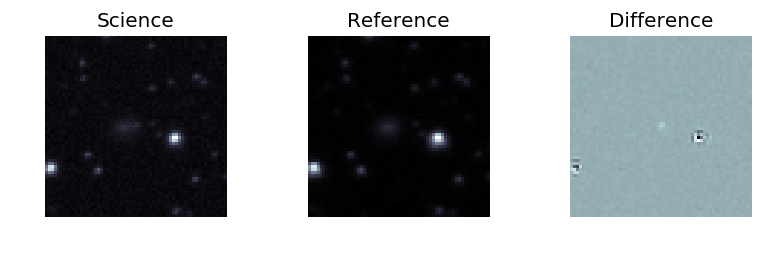

In [17]:
tr = make_triplet(alert)
plot_triplet(tr)

Light curve:

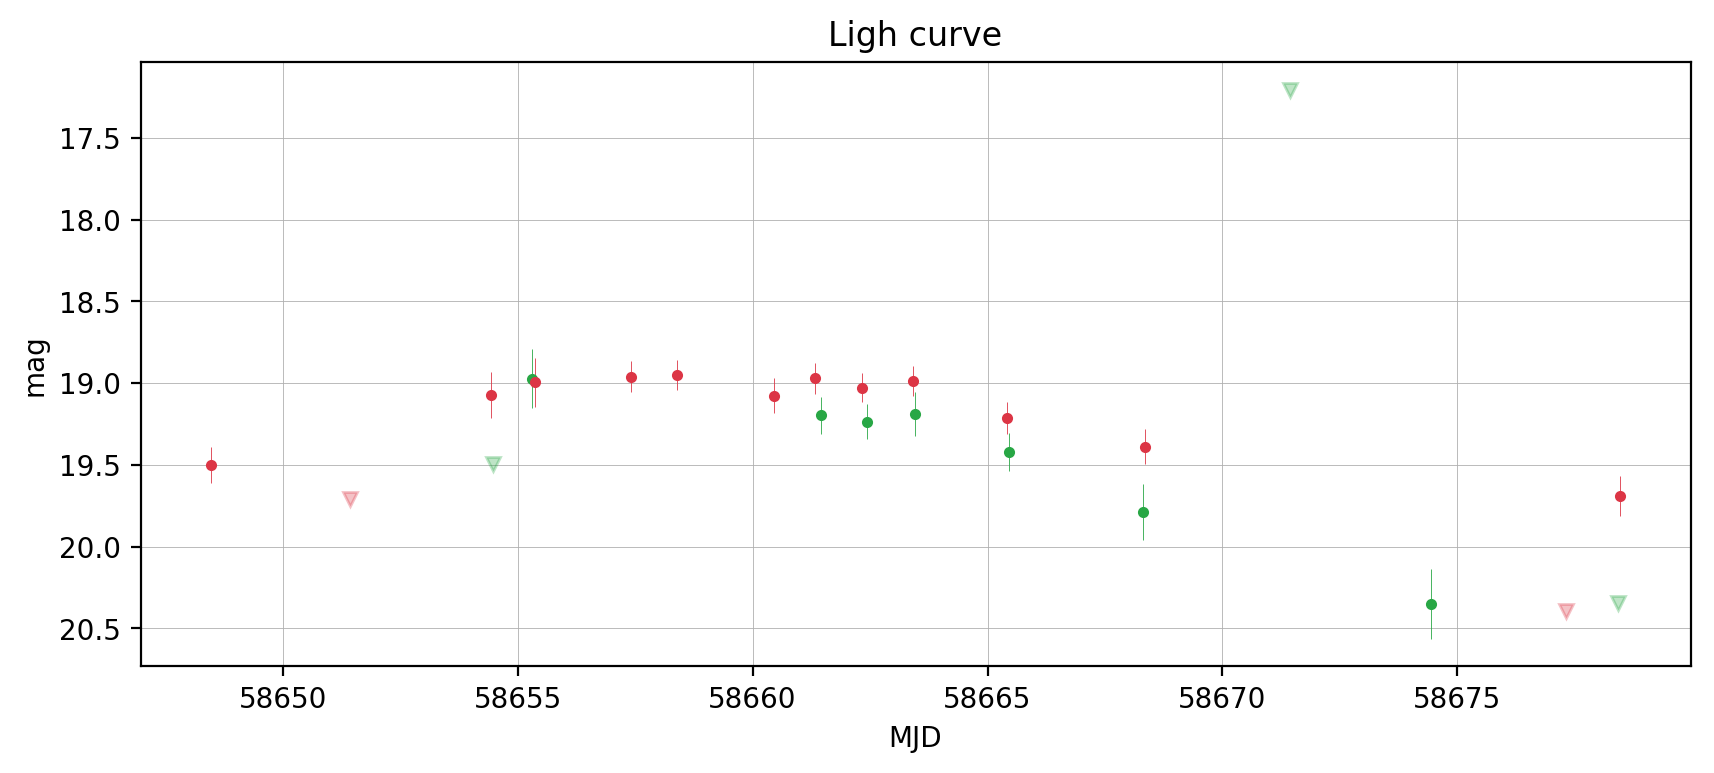

In [18]:
match_radius_arcsec = 1.5
star_galaxy_threshold = 0.4

_, lc_candid = assemble_lc(df, objectId=alert['objectId'], composite=False,
                               match_radius_arcsec=match_radius_arcsec,
                               star_galaxy_threshold=star_galaxy_threshold)
plot_lc(lc_candid)

#### A bogus detection caused by bad subtraction

In [19]:
candid = 924462626115010036

with open(f'20190714/{candid}.json', 'r') as f:
    alert = json.load(f)

In [20]:
display(JSON(alert))

<IPython.core.display.JSON object>

In [21]:
df = make_dataframe(alert)
display(df)

print(f"braai score: {df.loc[0, 'drb']:.2f}")

,jd,fid,pid,diffmaglim,pdiffimfilename,programpi,programid,candid,isdiffpos,tblid,...,zpmed,clrmed,clrrms,neargaia,neargaiabright,maggaia,maggaiabright,exptime,drb,drbversion
0,2.458679e+06,2,924462626115,20.376169,ztf_20190714462627_000593_zr_c16_o_q2_scimrefd...,TESS,1,924462626115010036,f,36,...,26.048,0.548,0.130577,1.3459,-999.0,15.356087,-999.0,30.0,0.018445,d6_m7
1,2.458649e+06,2,894471716115,20.679501,/ztf/archive/sci/2019/0614/471713/ztf_20190614...,Kulkarni,1,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.458651e+06,2,896352984815,19.708300,/ztf/archive/sci/2019/0616/352986/ztf_20190616...,Kulkarni,1,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.458651e+06,1,896460714815,19.880199,/ztf/archive/sci/2019/0616/460648/ztf_20190616...,Kulkarni,1,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.458652e+06,2,897423736115,19.672701,/ztf/archive/sci/2019/0617/423738/ztf_20190617...,Kulkarni,1,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2.458654e+06,1,899360024815,19.511499,/ztf/archive/sci/2019/0619/359954/ztf_20190619...,Kulkarni,1,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2.458654e+06,2,899419544815,19.742201,/ztf/archive/sci/2019/0619/419537/ztf_20190619...,Kulkarni,1,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2.458655e+06,2,900427314815,19.387199,/ztf/archive/sci/2019/0620/426979/ztf_20190620...,TESS,1,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2.458655e+06,2,900427786115,19.455000,/ztf/archive/sci/2019/0620/427766/ztf_20190620...,TESS,1,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2.458655e+06,1,900475316115,19.418699,/ztf/archive/sci/2019/0620/475301/ztf_20190620...,TESS,1,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


braai score: 0.02


Cutout images:

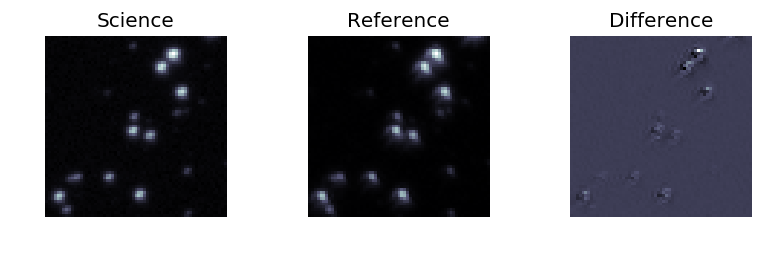

In [22]:
tr = make_triplet(alert)
plot_triplet(tr)

Light curve:

/Users/dmitryduev/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/dmitryduev/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


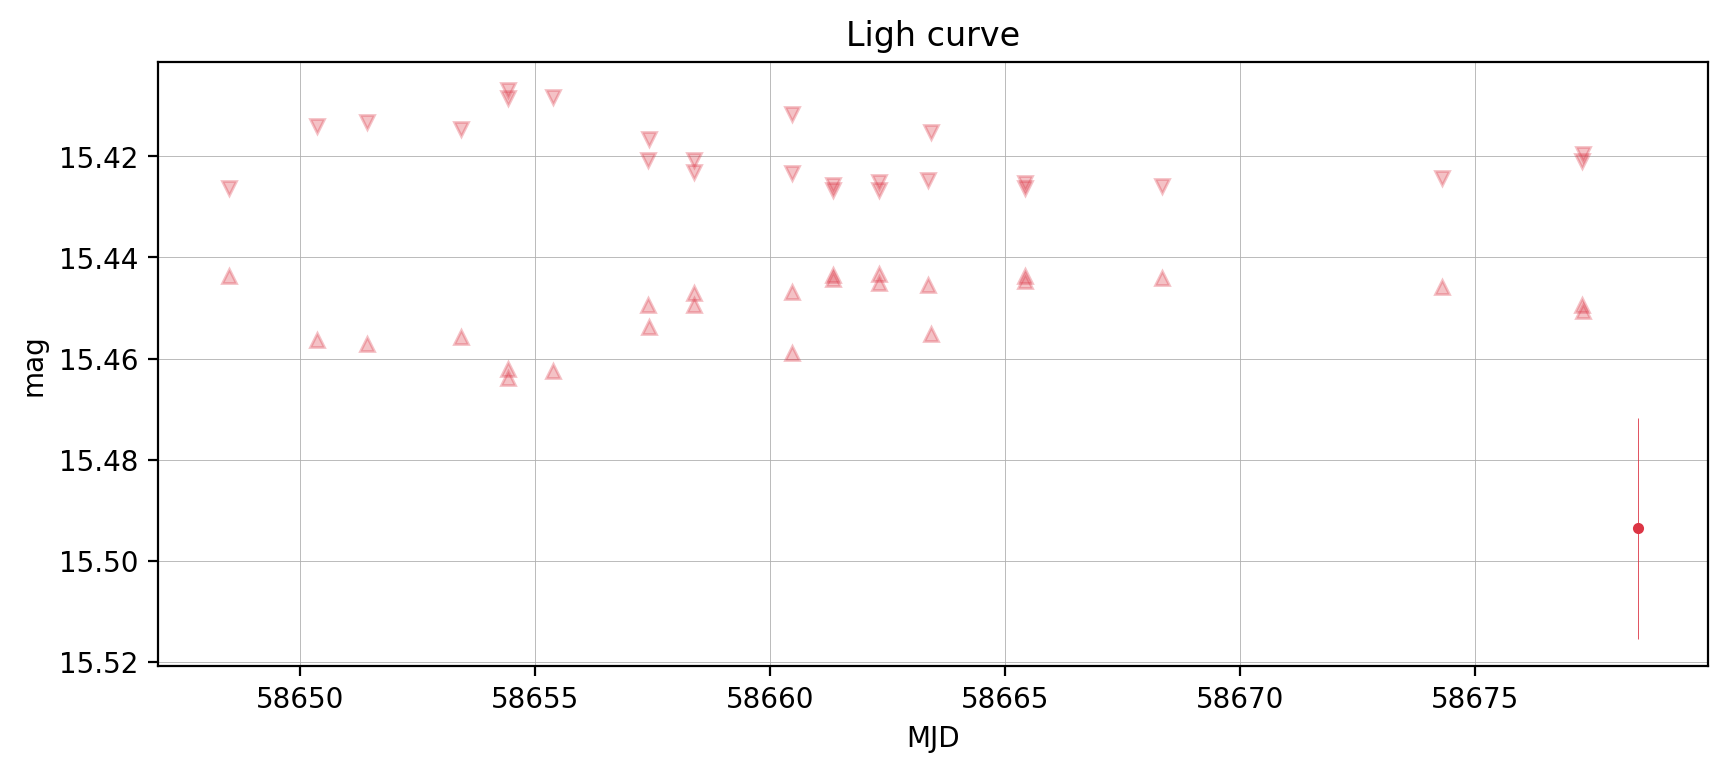

In [23]:
match_radius_arcsec = 1.5
star_galaxy_threshold = 0.4

_, lc_candid = assemble_lc(df, objectId=alert['objectId'], composite=False,
                               match_radius_arcsec=match_radius_arcsec,
                               star_galaxy_threshold=star_galaxy_threshold)
plot_lc(lc_candid)